In [1]:
import numpy as np
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Adaptive Denoising
def filter1(g, k, gamma, denoise_mode):
    # calculate the center of kernel
    a = k//2

    # create a zero matrix to fill with denoising result
    r = np.zeros(g.shape)

    # declaration of image dispersion measure, local dispersion measure and centrality measure
    gdisp = 0.0
    ldisp = 0.0
    centr = 0.0

    # compute the estimation of the image global dispersion in a determined subregion of the image accordig to the assignment description
    subregion = g[0:(g.shape[0]//6), 0:(g.shape[1]//6)]
    if(denoise_mode == "average"):
        gdisp = np.std(subregion)
    if(denoise_mode == "robust"):
        q1, c, q2 = np.percentile(subregion, [25, 50, 75])
        gdisp = q2 - q1

    # "If the dispersion measure computed for some image is 0, then manually set it to 1"
    if(gdisp == 0):
        gdisp = 1

    # loop to run all over the image and denoise it
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            # if running at the border of the image, when the filter kernel exceeds the limits of the image
            # then the resulting value is the copy of original image's pixel.
            if(x<a or x>(g.shape[0]-a) or y<a or y>(g.shape[1]-a)):
                r[x,y] = g[x,y]

            # else compute the filter
            else:
                # Sx is the image region, kernel size, to be filtered
                Sx = g[x-a:(x+a+1), y-a:(y+a+1)]
                
                # compute the local dispersion and centrality measure, according to denoise mode (average/robust)
                if(denoise_mode == "average"):
                    # if denoise mode is average, dispersion is standard deviation and the centrality is the mean of region Sx
                    ldisp = np.std(Sx)
                    centr = np.mean(Sx)
                elif(denoise_mode == "robust"):
                    # if denoise mode is robust, dispersion is interquartile range and the centrality is the median of region Sx
                    q1, centr, q2 = np.percentile(Sx, [25, 50, 75])
                    ldisp = q2 - q1
                
                # "If during the denoising step, any local dispersion measure is 0, then set it so that local dispersion = global dispersion"
                if(ldisp == 0):
                    ldisp = gdisp
                
                # formula of adaptive denoising
                r[x,y] = int(g[x,y] - gamma*(gdisp/ldisp)*(g[x,y]-centr))
    
    return r

In [3]:
# readjustment of range of values
def range_adjustment(img,minvalue=0,maxvalue=255):
    try:
        layers = img.shape[2]
    except:
        layers = 1
    
    img_u8 = np.zeros(img.shape, dtype=np.uint8)
    if(layers > 1):
        for z in range(layers):
            currmin = np.min(img[:,:,z])
            currmax = np.max(img[:,:,z])
            for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    img_u8[x,y,z] = ((img[x,y,z]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    else:
        currmin = np.min(img)
        currmax = np.max(img)
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                img_u8[x,y] = ((img[x,y]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    
    return img_u8 

In [4]:
img = imageio.imread("../images/shadow5.jpg")
for i in range(3):
    img[:,:,i] = filter1(img[:,:,i],3,0.005,"average")

In [5]:
# find the closest cluster to the example pixel
def closest_cluster(centroids, example):
    # calculate the euclidian distances of the example from all centroids
    distances = np.linalg.norm(np.subtract(centroids, example),axis=1)

    # return the cluster number in which there is the min distance value
    return (np.where(distances == np.min(distances))[0][0] + 1)

In [6]:
# after each iteration, the centroids coordinates are updated
def update_centroids(labeled_dataset, dataset, centroids):
    # for each centroid, compute the average values of all respective pixels attributes
    for c in range(centroids.shape[0]):
        # get all pixels that belongs to 'c' cluster
        cluster = dataset[np.where(labeled_dataset == c+1)]

        # compute the average of attributes values
        if(cluster.shape[0] != 0):
            centroids[c] = np.mean(cluster,axis=0)

    return centroids

In [7]:
# function to run the k-means routine in 'n' iterations
def kmeans_routine(dataset, centroids, k, n):
    r=centroids.shape[1]
    # create the frame for labeling the image
    label_img = np.zeros((dataset.shape[0],dataset.shape[1]), dtype=np.uint8)

    # loop to repeat 'n' times the iteration
    for iteration in range(n):
        # loops to run all dataset, labeling the objects according to centroids similarity
        for x in range(dataset.shape[0]):
            for y in range(dataset.shape[1]):
                if(np.sum(dataset[x,y]) == 0):
                    label_img[x,y] = 1
                else:
                    # collect an example object from dataset to be labeled
                    example = dataset[x,y]

                    # according to similarity, select the cluster in which the example belongs
                    cluster = closest_cluster(centroids, example)
                    # set the label_img pixel value to cluster's number
                    label_img[x,y] = cluster

        # update the centroids by calculating the average of attributes of each formed clusters
        centroids = update_centroids(label_img, dataset, centroids)
        
    return label_img

In [8]:
luminance_dataset = 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

# luminance_centroids = np.array([[np.min(luminance_dataset)], [np.max(luminance_dataset)]])
luminance_centroids = np.array([[np.min(luminance_dataset)], 
                                [np.max(luminance_dataset)/2], 
                                [np.max(luminance_dataset)]])

# lus = kmeans_routine(luminance_dataset, luminance_centroids, 2, 1)
lus = kmeans_routine(luminance_dataset, luminance_centroids, luminance_centroids.shape[0], 5)

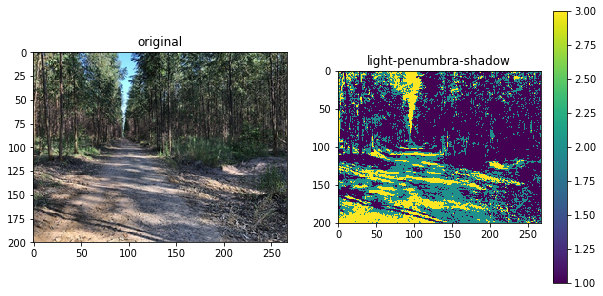

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title("original")
plt.subplot(122); plt.imshow(lus); plt.title("light-penumbra-shadow"); plt.colorbar()

Text(0.5, 1.0, 'shadow mask')

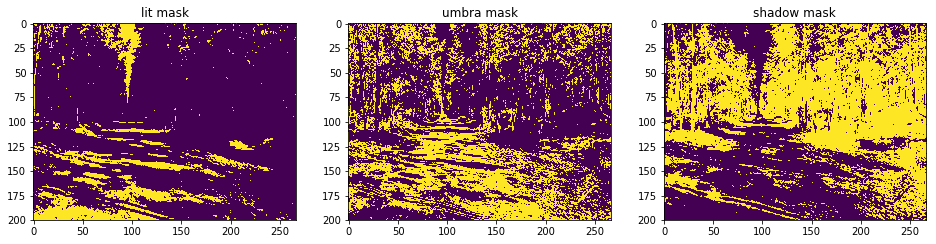

In [10]:
lit_mask = np.zeros((img.shape[0], img.shape[1]))
umbra_mask = np.zeros((img.shape[0], img.shape[1]))
shadow_mask = np.zeros((img.shape[0], img.shape[1]))

lit_mask[np.where(lus==3)] = 1
umbra_mask[np.where(lus==2)] = 1
shadow_mask[np.where(lus==1)] = 1

lit_img = np.zeros(img.shape, dtype=np.uint8)
umbra_img = np.zeros(img.shape, dtype=np.uint8)
shadow_img = np.zeros(img.shape, dtype=np.uint8)
for i in range(3):
    lit_img[:,:,i] = np.multiply(lit_mask,img[:,:,i])
    umbra_img[:,:,i] = np.multiply(umbra_mask,img[:,:,i])
    shadow_img[:,:,i] = np.multiply(shadow_mask,img[:,:,i])

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(lit_mask)
plt.title("lit mask")
plt.subplot(132)
plt.imshow(umbra_mask)
plt.title("umbra mask")
plt.subplot(133)
plt.imshow(shadow_mask)
plt.title("shadow mask")

In [11]:
def label_frame(frame, dataset, clusters):
    for i in range(1,np.max(clusters)+1):
        cluster = dataset[np.where(clusters == i)]
        coordinates = (cluster[:,-2],cluster[:,-1])
        frame[coordinates] = i
    
    return(frame)

In [12]:
lit_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(lus == luminance_centroids.shape[0])
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
lit_dataset = np.dstack(([img[np.where(lus == luminance_centroids.shape[0])]],
                           [coordinates]))


lit_centroids=np.array([[np.max(lit_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(lit_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(lit_dataset[:,:,1]),0,img.shape[0]//2,img.shape[1]-1],
                         [0,0,np.max(lit_dataset[:,:,2]),0,img.shape[1]//2]])

lit_clusters = kmeans_routine(lit_dataset, lit_centroids, 4, 2)

lit_clusters_mask = label_frame(lit_mask, lit_dataset, lit_clusters)

In [19]:
shadow_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(lus == 1)
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
shadow_dataset = np.dstack(([img[np.where(lus == 1)]],
                           [coordinates]))

shadow_centroids=np.array([[np.max(shadow_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(shadow_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(shadow_dataset[:,:,2]),0,img.shape[0]//2,img.shape[1]-1],
                         [0,0,np.max(shadow_dataset[:,:,2]),0,img.shape[1]//2]])

# shadow_centroids=np.array([[125,125,125,img.shape[0]-1,img.shape[1]//2],
#                          [125,125,125,img.shape[0]//2,0],
#                          [125,125,125,img.shape[0]//2,img.shape[1]-1]])

shadow_clusters = kmeans_routine(shadow_dataset, shadow_centroids, 3, 2)

shadow_clusters_mask = label_frame(shadow_mask, shadow_dataset, shadow_clusters)

In [20]:
umbra_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(lus == 2)
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
umbra_dataset = np.dstack(([img[np.where(lus == 2)]],
                           [coordinates]))

umbra_centroids=np.array([[np.max(umbra_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(umbra_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(umbra_dataset[:,:,2]),0,img.shape[0]//2,img.shape[1]-1],
                         [0,0,np.max(umbra_dataset[:,:,2]),0,img.shape[1]//2]])

# umbra_centroids=np.array([[125,125,125,img.shape[0]-1,img.shape[1]//2],
#                          [125,125,125,img.shape[0]//2,0],
#                          [125,125,125,img.shape[0]//2,img.shape[1]-1]])

umbra_clusters = kmeans_routine(umbra_dataset, umbra_centroids, 3, 2)

umbra_clusters_mask = label_frame(umbra_mask, umbra_dataset, umbra_clusters)

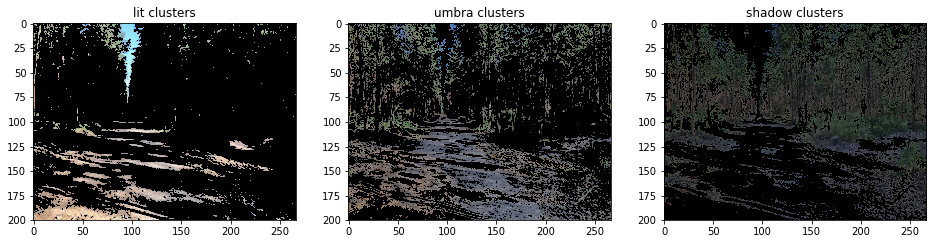

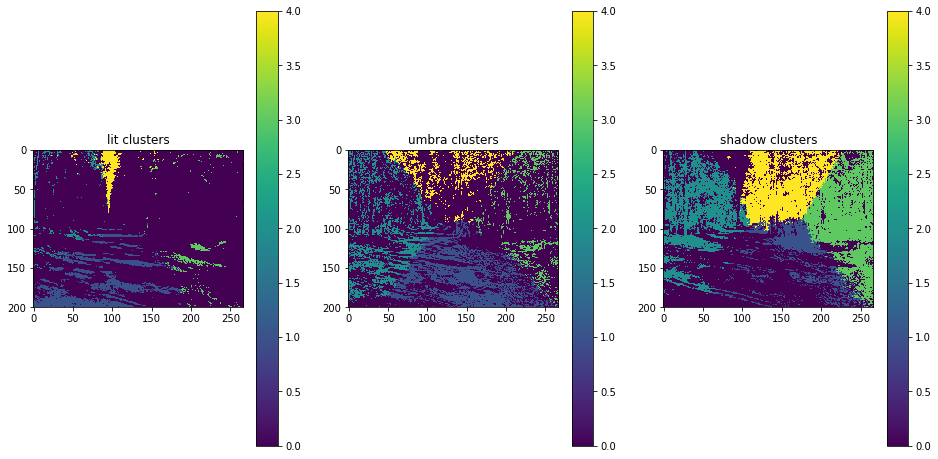

In [26]:
plt.figure(figsize=(16,8))
plt.subplot(131);plt.imshow(lit_img);plt.title("lit clusters")
plt.subplot(132);plt.imshow(umbra_img);plt.title("umbra clusters")
plt.subplot(133);plt.imshow(shadow_img);plt.title("shadow clusters")

plt.figure(figsize=(16,8))
plt.subplot(131);plt.imshow(lit_clusters_mask);plt.title("lit clusters");plt.colorbar()
plt.subplot(132);plt.imshow(umbra_clusters_mask);plt.title("umbra clusters");plt.colorbar()
plt.subplot(133);plt.imshow(shadow_clusters_mask);plt.title("shadow clusters");plt.colorbar()

In [16]:
# readjustment of range of values
def remove_shadow(img, shadow_mask, lit_mask):
    img_u8 = np.zeros(shadow.shape, dtype=np.uint8)
    
    for i in range(1,np.max(clusters)+1):
        cluster = dataset[np.where(clusters == i)]
        coordinates = (cluster[:,-2],cluster[:,-1])
        frame[coordinates] = i
    
    for z in range(3):
        minvalue = np.min()
        maxvalue = np.max()
        currmin = np.min(shadow[:,:,z])
        currmax = np.max(shadow[:,:,z])
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                img_u8[x,y,z] = ((img[x,y,z]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    
    return img_u8 

1
2
3
4


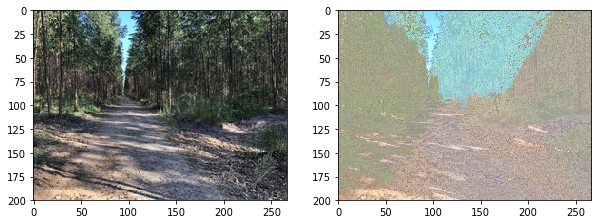

In [28]:
img_copy = np.copy(img)

# loop for each cluster
for g in range(1,5):
    print(g)
    umbra_coordinates = np.where(umbra_clusters_mask==g)

    # loop for each color layer
    for c in range(3):
        litmean = np.average(img[np.where(lit_clusters_mask==g)][:,c])
        litstd = np.std(img[np.where(lit_clusters_mask==g)][:,c])
        litmin = litmean - litstd
        litmax = litmean + litstd
        
        umbramin = np.min(img[umbra_coordinates][:,c])
        umbramax = np.max(img[umbra_coordinates][:,c])
        
        for i in range(umbra_coordinates[0].shape[0]):
            x,y,z=umbra_coordinates[0][i],umbra_coordinates[1][i],c
            img_copy[x,y,z]=((float(img[x,y,z])-umbramin)*(litmax - litmin)/(umbramax - umbramin)) + litmin

# loop for each cluster
for g in range(1,5):
    shadow_coordinates = np.where(shadow_clusters_mask==g)

    # loop for each color layer
    for c in range(3):
        litmean = np.average(img[np.where(lit_clusters_mask==g)][:,c])
        litstd = np.std(img[np.where(lit_clusters_mask==g)][:,c])
        litmin = litmean - litstd
        litmax = litmean + litstd
        
        shadowmin = np.min(img[shadow_coordinates][:,c])
        shadowmax = np.max(img[shadow_coordinates][:,c])
        
        for i in range(shadow_coordinates[0].shape[0]):
            x,y,z=shadow_coordinates[0][i],shadow_coordinates[1][i],c
            img_copy[x,y,z]=((float(img[x,y,z])-shadowmin)*(litmax - litmin)/(shadowmax - shadowmin)) + litmin
            
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_copy)

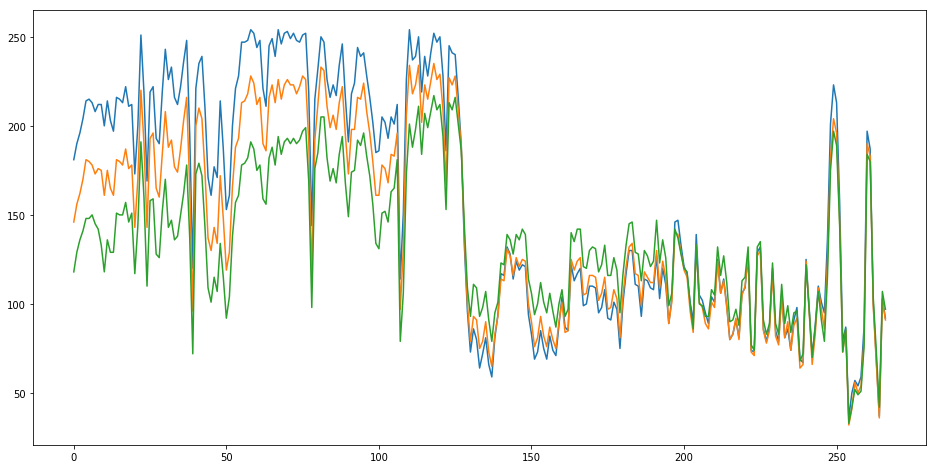

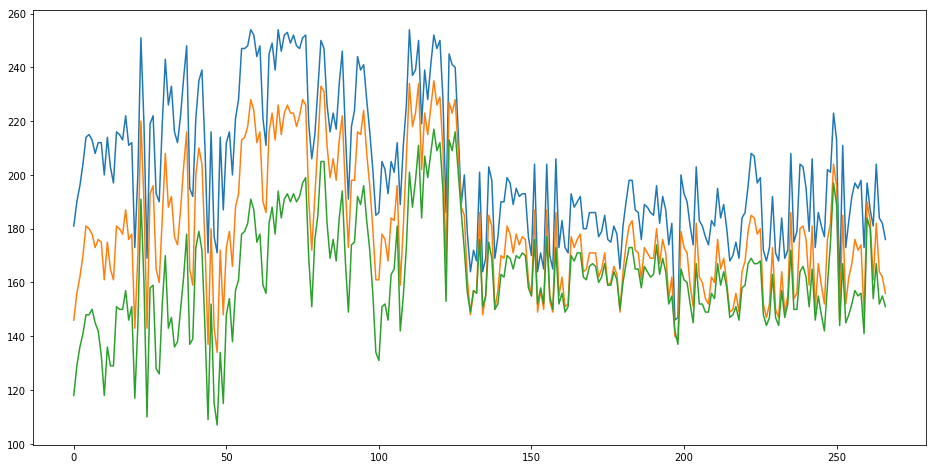

In [18]:
plt.figure(figsize=(16,8))
plt.plot(img[-1,:])
plt.figure(figsize=(16,8))
plt.plot(img_copy[-1,:])